In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

Загрузка библиотеки с FCA

In [2]:
import os
import sys
BASE_PATH = os.path.realpath('..')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

from lib import fca_interp as fcai

# Load Data

Все примеры будут приведены на основе Iris датасета. В нём даны измерения цветов ирисов, нужно определить их вид (setosa, virginica, versicolor).Т.е. задача 3х классовой классификации.

In [3]:
from sklearn.datasets import load_iris

iris_data = load_iris()
iris_ds = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
iris_ds['target'] = iris_data['target']
iris_ds.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Formal Contexts

Самый базовый случай FCA - работа с формальным (бинарным) контекстом

Сначала бинаризуем датасет

In [4]:
# Границы, на основе которых будут сформированы аттрибуты контекста
tholds = {'petal length (cm)': [2, 5],
         'petal width (cm)': [1.7]}

binarizer = fcai.Binarizer() 
# cases - словарь, аналогичный tholds.
# Задаёт особые случаи признаков. Например "petal length (cm) = 3.14"
iris_ds_bin = binarizer.binarize_ds(
    iris_ds, cat_feats=[], thresholds=tholds, cases={})[0]
print("Размер бинарного датасета:", iris_ds_bin.shape,
      "Кол-во уникальных строк и столбцов:",
      iris_ds_bin.drop_duplicates().T.drop_duplicates().T.shape)
iris_ds_bin.drop_duplicates().head(3)

Размер бинарного датасета: (150, 6) Кол-во уникальных строк и столбцов: (9, 6)


,petal length (cm)__geq__2,petal length (cm)__leq__2,petal length (cm)__geq__5,petal length (cm)__leq__5,petal width (cm)__geq__1.7,petal width (cm)__leq__1.7
0,False,True,False,True,False,True
50,True,False,False,True,False,True
70,True,False,False,True,True,False


Создадим на основе датасета формальный контекст cntx и объект класса FormalManager, который занимается всей работой с контекстом (расчёт понятий, метрик, визуализация)

In [5]:
cntx = fcai.BinaryContext(iris_ds_bin, y_true=iris_ds['target'])
fm = fcai.FormalManager(cntx)

Расчитаем понятия в контексте. По умолчанию используется алгоритм из python библиотеки "concepts". Также реализован CbO.

In [6]:
%%time
fm.construct_concepts()


CPU times: user 68.2 ms, sys: 12 ms, total: 80.2 ms
Wall time: 81.3 ms


Небольшая доработка, которую нужно будет пронести в библиотеку

Пронумеруем все понятия по убыванию их объёма. Т.о. самое большое (общее) понятие будет иметь индекс 0, самое маленькое (частное) - максимально возможный индекс.

In [7]:
for idx, c in enumerate(fm.sort_concepts()): 
    # нумерием понятие
    c._idx = idx
    # обновляем объём. Раньше он использовал объём
    # только из сокращённого контекста, где все объекты уникальны.
    # Теперь в объёме будут объекты из полного контекста
    c._extent = fm.get_context().get_extent(c.get_intent(), is_full=True)

Рассчитываем решётку понятий

In [8]:
%%time
fm.construct_lattice()

CPU times: user 4.53 ms, sys: 186 µs, total: 4.72 ms
Wall time: 6.88 ms


Вручную рассчитаем метрики для классификации объектов.

В случае с регрессией и бинарной классификацией этого можно не делать, - всё пройдёт автоматически.

In [9]:
for idx, c in enumerate(fm.sort_concepts()):
    # индексы объектов из объёма понятия
    ext_idxs = fm.get_context().get_extent(
        c.get_intent(), verb=False, is_full=True)
    # инициализируем вероятность предсказываемого класса.
    c._metrics['class_prob_max'] = 0 
    # инициализируем предсказываемый класс
    c._metrics['class_id_predict'] = 0 
    
    for target_id, target_name in enumerate(
        iris_data['target_names']
    ):
        # вероятность класса x - 
        # доля объектов с таким классом в объёме понятия
        metric_name = f'class_{target_id}_prob'
        c._metrics[metric_name] = (
            fm.get_context()._y_true[ext_idxs]==target_id
        ).mean()
        
        # обновляем класс, предсказываемый понятием
        if c._metrics[metric_name]>c._metrics['class_prob_max']:
            c._metrics['class_prob_max'] = c._metrics[metric_name]
            c._metrics['class_id_predict'] = target_id
    # добавляем название предсказываемого класса
    c._metrics['class_name_predict'] = iris_data['target_names'][
        c._metrics['class_id_predict']]

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Визуализируем решётку

In [10]:
classes_str = ",".join([f"{idx}={x}"
    for idx, x in enumerate(iris_data["target_names"])])

fig = fm.get_plotly_fig(
    # сортировка понятий по горизонтали
    sort_by='class_id_predict', level_sort='all', 
    # работа с цветом понятий
    color_by='class_id_predict', cmap='Portland', 
    opacity_by='class_prob_max', cbar_title='Target class id',
    # если в понятии появилось >= 1 нового объекта 
    # - выводим только кол-во новых объектов, а не их индексы
    new_objs_lim=1,
    title="Concept Lattice for binarized Iris dataset<br>"+\
     f'Classes: {classes_str}<br>'+\
     "Opacity ~ Confidence",
)

Стандартный вид решётки понятий
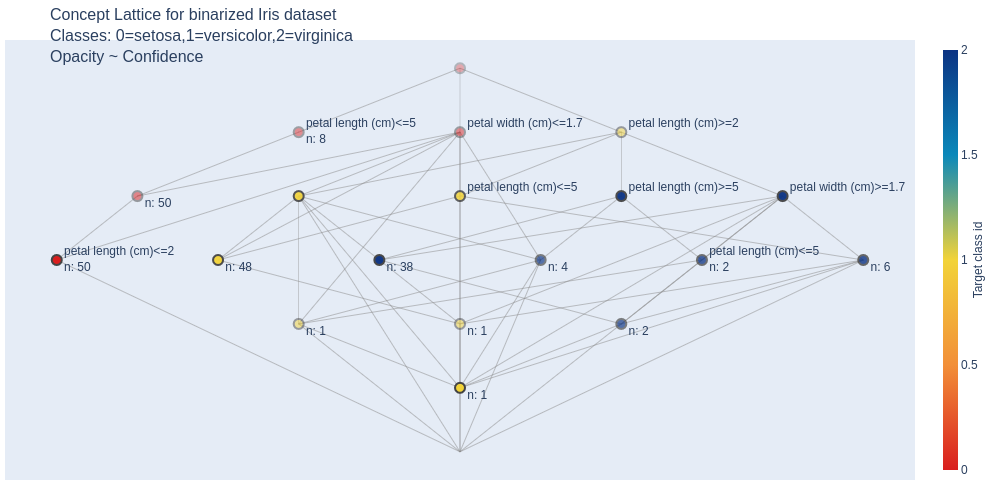

Решётка понятий с активированным понятием (активация с помощью наведения мыши на понятие)
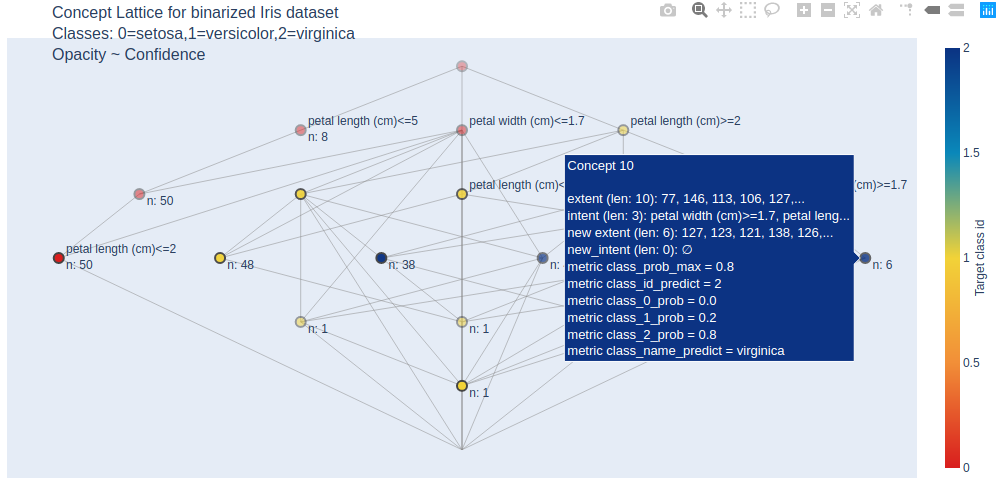

# Multi-valued contexts

Работа с узорными структурами.


Сейчас реализованы только:
* интервальная узорная структура ($g^{'} = [a_{min}, a_{max}], \quad g_1^{'}\sqcap g_2^{'} = [min(a_{1_{min}}, a_{2_{min}}), max(a_{1_{max}}, a_{2_{max}}  )],\quad$ где $g$ - объект, $a_{min}, a_{max} \in \mathbb{R}$)
* узорная структура на множествах ($g^{'} = A, \quad g_1^{'}\sqcap g_2^{'} = A_1 \cap A_2,\quad$ где $g$ - объект, $A \subseteq W$,$W$ - множество каких-то значений)

## Full lattice construction

В полной решётке понятий может оказаться много понятий, поэтому возмём лишь небольшую часть датасета

In [11]:
cds = iris_ds.sample(10, random_state=42)
# cat_attrs - категориальные признаки.
# на них строятся узорные понятия на множествах.
# остальные признаки считаются интервальными
mvcntx_short = fcai.MultiValuedContext(
    cds.drop('target',1), y_true=cds['target'], cat_attrs=[])
fm_mv_short = fcai.FormalManager(mvcntx_short)

Рассчитываем понятия

In [12]:
%%time
fm_mv_short.construct_concepts(use_tqdm=True)


CPU times: user 107 ms, sys: 12.6 ms, total: 119 ms
Wall time: 108 ms


Небольшой костыль - добавляем в решётку самое меньшее понятие, которое ничего не описывает. Это нужно только для красивой визуализации и корректного расчёта индексов стабильности.

In [13]:
fm_mv_short._concepts.add(
    fcai.PatternStructure(
        extent=[], intent=None, cat_feats=[],
        idx=len(fm_mv_short.get_concepts()))
)

Рассчитываем решётку понятий. Для оптимизации процесса сначала строится остовное дерево, находятся все цепочки понятий и по ним выстраивается вся решётка.

In [14]:
%%time
fm_mv_short.construct_lattice(use_tqdm=True)


CPU times: user 375 ms, sys: 10.5 ms, total: 385 ms
Wall time: 378 ms


Рассчёт индексов стабильности (логарифмической нижней границы и $\Delta$-стабильности)

In [15]:
%%time
fm_mv_short.calc_stability_approx()

CPU times: user 64.7 ms, sys: 10.6 ms, total: 75.3 ms
Wall time: 74.6 ms


Визуализация решётки с точки зрения стабильности понятий

In [16]:
fig_mv_short = fm_mv_short.get_plotly_fig(
    new_attrs_lim=1, new_objs_lim=1,
    color_by='stab_min_bound', cbar_title='min delta stability',
    title='Lattice of small part of Iris dataset'
)

Решётка понятий на интервальной узорной структуре. Цвет соответствует индексу $\Delta$-стабильности понятия.
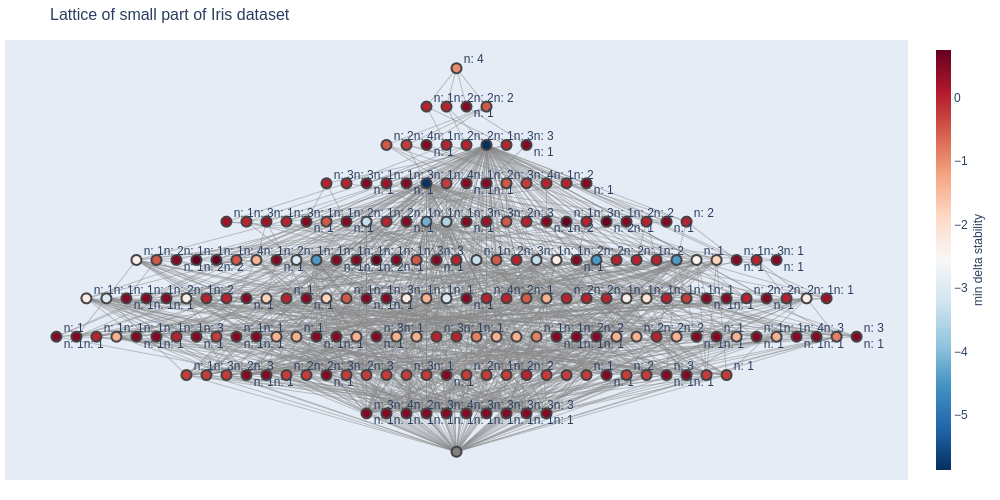

## Lattice construction on big data for supervised learning

На больших контекстах нет смысла рассчитывать все понятия. Будем аппроксимировать решётку через объединение нескольких деревьев решений (про это будет моя магистерская). Возможно такую решётку нельзя будет рассматривать, как средство для KDD (тут лучше пользоваться алгоритмом sofia, который у меня пока не имплементирова), зато её можно использовать для классификации объектов.

### Конструирование аппроксимированной решётки

Делим контекст на обучающую и тестовую выборки.

In [17]:
np.random.seed(42)
train_idxs = np.random.choice(iris_ds.index, size=100, replace=False,)

mvcntx_train = fcai.MultiValuedContext(
    iris_ds.loc[train_idxs].drop('target',1),
    y_true=iris_ds.loc[train_idxs, 'target'], 
    cat_attrs=[]
)
mvcntx_test = fcai.MultiValuedContext(
    iris_ds.drop(train_idxs).drop('target',1),
    y_true=iris_ds.drop(train_idxs)['target'],
    cat_attrs=[]
)
fm_mv = fcai.FormalManager(mvcntx_train)

Строим понятия на обучающей выборке

In [18]:
%%time
fm_mv.construct_concepts(
    use_tqdm=True, algo='RandomForest',
    rf_params={'n_estimators':100})


CPU times: user 228 ms, sys: 7.53 ms, total: 235 ms
Wall time: 231 ms


Небольшой костыль - добавляем в решётку самое меньшее понятие, которое ничего не описывает. Это нужно только для красивой визуализации и корректного расчёта индексов стабильности.

In [19]:
fm_mv._concepts.add(
    fcai.PatternStructure(
        extent=[], intent=None, cat_feats=[],
        idx=len(fm_mv.get_concepts())))

Строим остовное дерево на понятиях. Для классификации объектов не обязательно рассчитывать всю решётку, все связи между понятиями.

In [20]:
%%time
fm_mv.construct_lattice(use_tqdm=True, only_spanning_tree=True)


CPU times: user 47.1 ms, sys: 619 µs, total: 47.7 ms
Wall time: 45.6 ms


Небольшой костыль, чтобы можно было визуализировать получившееся остовное дерево. При расчёте решётки понятий этот код происходит автоматически.

In [21]:
for c in fm_mv.get_concepts():
    c._up_neighbs = {c._up_neighb_st} \
        if c._up_neighb_st is not None else None
    c._low_neighbs = c._low_neighbs_st

fm_mv._calc_concept_levels() # расчёт горизонтальной координаты при отображении понятия

Рассчёт метрик для классификации

In [22]:
for idx, c in enumerate(fm_mv.sort_concepts()):
    c._idx = idx
    
    ext_idxs = fm_mv.get_context().get_extent(
        c.get_intent(), verb=False)
    c._metrics['class_prob_max'] = 0
    c._metrics['class_id_predict'] = 0
    
    for target_id, target_name in enumerate(iris_data['target_names']):
        metric_name = f'class_{target_id}_prob'
        c._metrics[metric_name] = (
            fm_mv.get_context()._y_true[ext_idxs]==target_id).mean()
        
        if c._metrics[metric_name]>c._metrics['class_prob_max']:
            c._metrics['class_prob_max'] = c._metrics[metric_name]
            c._metrics['class_id_predict'] = target_id
    c._metrics['class_name_predict'] = iris_data['target_names'][
        c._metrics['class_id_predict']]

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Визуализируем остовное дерево

In [23]:
classes_str = ",".join([f"{idx}={x}"
    for idx, x in enumerate(iris_data["target_names"])])

fig_mv = fm_mv.get_plotly_fig(
    # отображаем только кол-во изменившихся аттрибутов
    # и кол-во новых объектов в понятии
    new_attrs_lim=1, new_objs_lim=1, 
    # работа с цветом понятий
    color_by='class_id_predict', cbar_title='Target class id',
    cmap='Portland', opacity_by='class_prob_max',
    # сортировка понятий по горизонтали
    level_sort='all', sort_by='class_id_predict', 
    title="Approximate Concept Lattice for Iris dataset<br>"+\
        f'Classes: {classes_str}<br>'+\
        "Opacity ~ Confidence""",
)

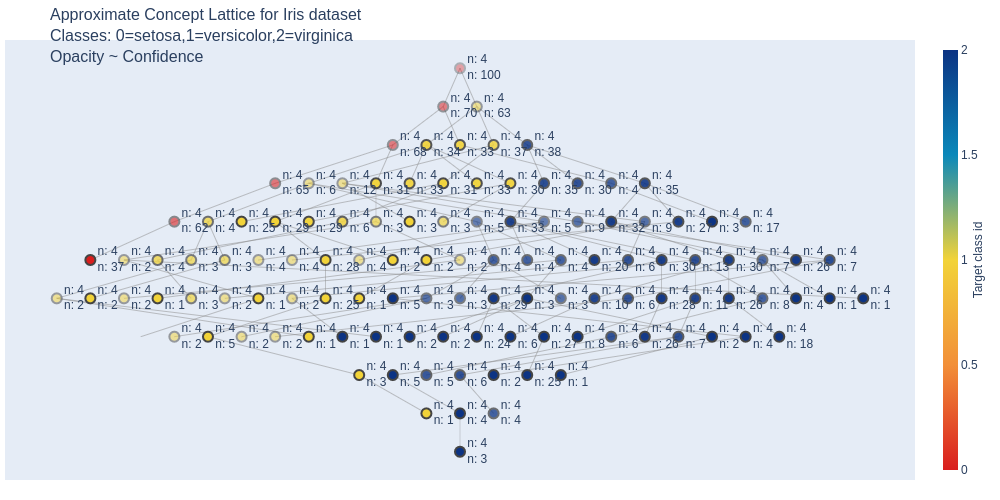

### Классификация с помощью решётки

Алгоритм классификации объекта $g$:
1. Найти множество $C^g$ минимальных (по включению) понятий, которые описывают объект $g$
2. Предсказание для объекта $g$ = среднее из предсказаний каждого понятия из $C^g$

Получаем предсказания (в виде вероятностей) для каждого объекта из обучающего и тестового контекстов

In [24]:
%%time
metrics = [f'class_{i}_prob' for i in range(3)]
probs_train = fm_mv.predict_context(
    mvcntx_train, metric=metrics)
probs_test = fm_mv.predict_context(
    mvcntx_test, metric=metrics)
probs_test[[0,10,20]]

CPU times: user 38 ms, sys: 4.4 ms, total: 42.4 ms
Wall time: 37.7 ms


matrix([[1.        , 0.        , 0.        ],
        [0.59677419, 0.40322581, 0.        ],
        [0.06324786, 0.73402702, 0.20272512]])

Преобразуем вероятности в индексы классов

In [25]:
preds_train = np.array(probs_train.argmax(1)).flatten()
preds_test = np.array(probs_test.argmax(1)).flatten()

Качество на обучающей и тестовой выборке

In [26]:
print('train accuracy:',
      (preds_train==iris_ds.loc[train_idxs, 'target']).mean())
print('test accuracy:',
      (preds_test==iris_ds.drop(train_idxs)['target']).mean())

train accuracy: 0.99
test accuracy: 0.88


Пример неправильно предсказанного объекта

In [27]:
print('Wrongly classified object #13 (dataset index=50)')
print('Class predictions:', np.array(probs_test[13]).flatten())
print('True label:', mvcntx_test._y_true[13])
print()
print('Concepts used for prediciton:',
      fm_mv.trace_context(mvcntx_test)[0][13])

Wrongly classified object #13 (dataset index=50)
Class predictions: [0.         0.16666667 0.83333333]
True label: 1

Concepts used for prediciton: [21]


При предсказании объекта используется всего одно понятие. Можно его вывести и проанализировать

In [28]:
c = fm_mv.get_concept_by_id(21)
print(f'Pattern Concept #{c._idx}')
print(f'Extent: {len(c.get_extent())}'+\
    ' objects: as example '+\
    f'{",".join([str(x) for x in c.get_extent()[:5]])},...')
print('Description:')
for k,v in c.get_intent().items():
    print(f'  {k} in [{v[0]}, {v[1]}]')
print('Metrics:')
for idx, t in enumerate(iris_data['target_names']):
    print(f"  Class \'{t}\' proportion: {c._metrics[f'class_{idx}_prob']:.2%}")
print()
print(f'Final prediction: class \''+\
    f'{c._metrics["class_name_predict"]}\''+\
    f' with {c._metrics["class_prob_max"]:.2%} probability')

Pattern Concept #21
Extent: 30 objects: as example 99,94,93,91,84,...
Description:
  sepal length (cm) in [6.1, 7.9]
  sepal width (cm) in [2.5, 3.8]
  petal length (cm) in [4.7, 6.9]
  petal width (cm) in [1.2, 2.5]
Metrics:
  Class 'setosa' proportion: 0.00%
  Class 'versicolor' proportion: 16.67%
  Class 'virginica' proportion: 83.33%

Final prediction: class 'virginica' with 83.33% probability


# Планы на будущее

__Доработки узорных структур__
* Расчёт генераторов узорных понятий и отображение их на графике
* Рефакторинг кода для быстрого добавления новых понятий и их проекций
* Разработка алгоритма для аппроксимации решётки через деревья решений для узорных понятий (часть магистерской)

__Визуализация__
* Отображение решётки с минимальным кол-вом пересекающихся линий
* Интерактивные ассоциативные связи между понятиями
* Интерактивное выделение части решётки, связанных с каким-то понятием

__Оптимизация__
* хранение объёмов понятий в виде разреженной матрицы "id объекта"x"id понятия"

__Рефакторинг кода__
* убрать legacy код
* добавить комментарии и docstring'и